# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

## Table of Contents

[Part 0: Explore Data](#Get-to-Know-the-Data)<br>
[Part 1: Customer Segmentation Report](#part1)<br>
[Part 2: Supervised Learning Model](#part2)<br>
[Part 3: Kaggle Competition](#part3)<br>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostRegressor 
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn import metrics

%matplotlib inline


In [2]:
import platform
platform.architecture()

('64bit', 'WindowsPE')

## <a class="anchor" id="Get-to-Know-the-Data">Part 0: Get to Know the Data</a>

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. I will use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use my analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, I will refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.


In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

C:\Users\ahmad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!


In [5]:
feature_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [6]:
azdias.shape

(891221, 366)

In [7]:
list(azdias.columns)

['LNR',
 'AGER_TYP',
 'AKT_DAT_KL',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'ALTERSKATEGORIE_FEIN',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_KINDER',
 'ANZ_PERSONEN',
 'ANZ_STATISTISCHE_HAUSHALTE',
 'ANZ_TITEL',
 'ARBEIT',
 'BALLRAUM',
 'CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'CJT_GESAMTTYP',
 'CJT_KATALOGNUTZER',
 'CJT_TYP_1',
 'CJT_TYP_2',
 'CJT_TYP_3',
 'CJT_TYP_4',
 'CJT_TYP_5',
 'CJT_TYP_6',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_DIREKT',
 'D19_BANKEN_GROSS',
 'D19_BANKEN_LOKAL',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_BANKEN_REST',
 'D19_BEKLEIDUNG_GEH',
 'D19_BEKLEIDUNG_REST',
 'D19_BILDUNG',
 'D19_BIO_OEKO',
 'D19_BUCH_CD',
 'D19_DIGIT_SERV',
 'D19_DROGERIEARTIKEL',
 'D19_ENERGIE',
 'D19_FREIZEIT',
 'D19_GARTEN',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE

In [8]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


## <a class="anchor" id="part1">Part 1: Customer Segmentation Report</a>

The main bulk of the analysis will come in this part of the project. Here, I will use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, I should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### Step 1: Preprocessing

####  Step 1.1:  Assess Missing Data

In [9]:
# Laod DIAS Attributes
dias_attributes = pd.read_excel('./DIAS Attributes - Values 2017.xlsx', skiprows=[0])
del dias_attributes['Unnamed: 0']

# Drop NaN attribute
dias_attributes.dropna(subset=['Attribute'],inplace = True)

# Drop attribute described in feat_info
dias_attributes = dias_attributes[~dias_attributes['Attribute'].isin(feature_info.attribute)]


In [10]:
# dias_attributes shape
dias_attributes.shape

(233, 4)

In [11]:
# Explore attribute with unknown Meaning
un_Meaning = dias_attributes[dias_attributes['Meaning'] == 'unknown']

# Keep only attribute which we are interested in
un_Meaning = un_Meaning[un_Meaning['Attribute'].isin(azdias.columns)]

# unknown_Meaning shape
un_Meaning.shape

(164, 4)

In [12]:
un_Meaning['first_attribute'] = un_Meaning.Attribute.apply(lambda x: x.split('_')[0])

**encode KBA13 and KBA05 as ordinals**

In [13]:
un_Meaning['type'] = 'ordinal'

In [14]:
# explore attribute with no transaction known
no_trans = dias_attributes[dias_attributes['Meaning'].isin(['no transaction known','no transactions known'])]

# Keep only attribute which we are interested in
no_trans = no_trans[no_trans['Attribute'].isin(azdias.columns)]

# Get first part of attribute
no_trans['first_attribute'] = no_trans.Attribute.apply(lambda x: x.split('_')[0])

# unknown_Meaning shape
no_trans.shape

(10, 5)

**Encode D19 as ordinals variables**

In [15]:
no_trans['type'] = 'ordinal'

In [16]:
# Explore the rest of attributes 
sub_dias_atrribute = dias_attributes[~dias_attributes['Meaning'].isin(['no transaction known',
                                                             'no transactions known',
                                                            'unknown'])]

# Keep only attribute which we are interested in
sub_dias_atrribute = sub_dias_atrribute[sub_dias_atrribute['Attribute'].isin(azdias.columns)]

# Get first part of attribute
sub_dias_atrribute['first_attribute'] = sub_dias_atrribute.Attribute.apply(lambda x: x.split('_')[0])


sub_dias_atrribute.shape

(17, 5)

In [17]:
sub_dias_atrribute['type'] = sub_dias_atrribute.Meaning.apply(lambda x: 'categorical' if x=='Universal' else 'ordinal')

In [18]:
sub_dias_atrribute.columns

Index(['Attribute', 'Description', 'Value', 'Meaning', 'first_attribute',
       'type'],
      dtype='object')

In [19]:
un_Meaning.columns

Index(['Attribute', 'Description', 'Value', 'Meaning', 'first_attribute',
       'type'],
      dtype='object')

In [20]:
# Make a dataframe of features proprieties
def_cl = lambda x: [str(k) for k in str(x).split(',')]
un_Meaning['missing_or_unknown'] = un_Meaning.Value.apply(def_cl)

# Drop colums
un_Meaning.drop(['Description', 'Value', 'Meaning', 'first_attribute'],
                    axis=1, inplace=True)

# Change columns name
un_Meaning.columns = ['attribute', 'type', 'missing_or_unknown']

un_Meaning.head()

,attribute,type,missing_or_unknown
765,KBA05_ALTER1,ordinal,"[-1, 9]"
771,KBA05_ALTER2,ordinal,"[-1, 9]"
777,KBA05_ALTER3,ordinal,"[-1, 9]"
783,KBA05_ALTER4,ordinal,"[-1, 9]"
790,KBA05_ANHANG,ordinal,"[-1, 9]"


In [21]:
# no_transaction
no_trans['missing_or_unknown'] = no_trans.Value.apply(lambda x: [str(x)])

# Drop colums
no_trans.drop(['Description', 'Value', 'Meaning', 'first_attribute'],
                    axis=1, inplace=True)

# Change columns name
no_trans.columns = ['attribute', 'type', 'missing_or_unknown']

no_trans.head()

,attribute,type,missing_or_unknown
138,D19_BANKEN_ANZ_12,ordinal,[0]
145,D19_BANKEN_ANZ_24,ordinal,[0]
305,D19_GESAMT_ANZ_12,ordinal,[0]
312,D19_GESAMT_ANZ_24,ordinal,[0]
478,D19_TELKO_ANZ_12,ordinal,[0]


In [22]:
sub_dias_atrribute.columns

Index(['Attribute', 'Description', 'Value', 'Meaning', 'first_attribute',
       'type'],
      dtype='object')

In [23]:
#sub_dias_atrribute
sub_dias_atrribute['missing_or_unknown'] =sub_dias_atrribute.Value.apply(lambda x: [])
     
# Drop colums
sub_dias_atrribute.drop(['Description', 'Value', 'Meaning', 'first_attribute'],
              axis=1, inplace=True)

# Change columns name
sub_dias_atrribute.columns = ['attribute', 'type', 'missing_or_unknown']

sub_dias_atrribute.head()

,attribute,type,missing_or_unknown
152,D19_BANKEN_DATUM,ordinal,[]
186,D19_BANKEN_OFFLINE_DATUM,ordinal,[]
196,D19_BANKEN_ONLINE_DATUM,ordinal,[]
206,D19_BANKEN_ONLINE_QUOTE_12,ordinal,[]
319,D19_GESAMT_DATUM,ordinal,[]


In [24]:

feature_info['missing_or_unknown'] = feature_info['missing_or_unknown'].apply(lambda x: x[1:-1].split(','))
# Drop information_level 
feature_info.drop(['information_level'], axis=1,inplace = True)

feature_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [25]:
# merge into new feature_info datafrae
new_feature_info = pd.concat([feature_info, sub_dias_atrribute, no_trans,un_Meaning], ignore_index=True)

In [26]:
new_feature_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [27]:
# Shape of new_feat_info
new_feature_info.shape

(276, 3)

In [28]:
# Columns without type
columns = azdias.columns[~azdias.columns.isin(new_feature_info.attribute)]


In [29]:
columns

Index(['LNR', 'AKT_DAT_KL', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_KINDER',
       'ANZ_STATISTISCHE_HAUSHALTE', 'CJT_KATALOGNUTZER', 'CJT_TYP_1',
       'CJT_TYP_2', 'CJT_TYP_3', 'CJT_TYP_4', 'CJT_TYP_5', 'CJT_TYP_6',
       'D19_BANKEN_DIREKT', 'D19_BANKEN_GROSS', 'D19_BANKEN_LOKAL',
       'D19_BANKEN_REST', 'D19_BEKLEIDUNG_GEH', 'D19_BEKLEIDUNG_REST',
       'D19_BILDUNG', 'D19_BIO_OEKO', 'D19_BUCH_CD', 'D19_DIGIT_SERV',
       'D19_DROGERIEARTIKEL', 'D19_ENERGIE', 'D19_FREIZEIT', 'D19_GARTEN',
       'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_KINDERARTIKEL',
       'D19_KONSUMTYP_MAX', 'D19_KOSMETIK', 'D19_LEBENSMITTEL',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_NAHRUNGSERGAENZUNG',
       'D19_RATGEBER', 'D19_REISEN', 'D19_SAMMELARTIKEL', 'D19_SCHUHE',
       'D19_SONSTIGE', 'D19_SOZIALES', 'D19_TECHNIK', 'D19_TELKO_MOBILE',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_TELKO_REST', 'D19_TIERARTIKEL',
       'D19_VERSAND_R

In [30]:
# Data information
dias_info = pd.read_excel('./DIAS Information Levels - Attributes 2017.xlsx',
                          skiprows=[0])
del dias_info['Unnamed: 0']
dias_info = dias_info[dias_info.Attribute.isin(columns)]

dias_info.head()

,Information level,Attribute,Description,Additional notes
67,NaN,D19_VERSI_OFFLINE_DATUM,actuality of the last transaction for the segm...,NaN
68,NaN,D19_VERSI_ONLINE_DATUM,actuality of the last transaction for the segm...,NaN
69,NaN,D19_VERSI_DATUM,actuality of the last transaction for the segm...,NaN


In [31]:
# List of columns to drop
drop_columns = list(azdias[columns].select_dtypes(include='object').columns)

In [32]:
drop_columns

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [33]:
last_attribute_info = pd.DataFrame({'attribute': list(azdias[columns].describe().columns)})
last_attribute_info['type'] = 'numeric'
last_attribute_info['missing_or_unknown'] = last_attribute_info['type'].apply(lambda x: [])

last_attribute_info.head()

,attribute,type,missing_or_unknown
0,LNR,numeric,[]
1,AKT_DAT_KL,numeric,[]
2,ALTER_KIND1,numeric,[]
3,ALTER_KIND2,numeric,[]
4,ALTER_KIND3,numeric,[]


In [34]:
# Concat last_att_info and new_feat_info
new_feature_info = pd.concat([new_feature_info, last_attribute_info], ignore_index=True)

new_feature_info.shape

(364, 3)

In [35]:
new_feature_info.columns

Index(['attribute', 'type', 'missing_or_unknown'], dtype='object')

In [36]:
for attribute, missings in zip(new_feature_info['attribute'],
                                  new_feature_info['missing_or_unknown']):
    if len(missings) != 0:
        for val in missings:
            if val.isnumeric() or val.lstrip('-').isnumeric():
                val = int(val)
            azdias.loc[azdias[attribute] == val, attribute] = np.nan

C:\Users\ahmad\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [37]:
# Drop col_to_drop
azdias.drop(drop_columns, axis=1, inplace=True)

# azdias shape
azdias.shape

(891221, 364)



**since most machine learning algorthims are senstive to null values thus I am going to perform two dropping steps one on the columns level and the second on each row**

In [38]:
# Missing Data in Each Column
nans_col = azdias.isnull().sum()/len(azdias)

In [39]:
azdias.drop(list(nans_col[nans_col > 0.3].index), axis=1,inplace= True)

In [40]:
# Remove the outlier missing_col from the dataset.
len(list(nans_col[nans_col > 0.3].index))

21

In [41]:
azdias.shape

(891221, 343)

In [42]:
# Drop row that contains more than 60% of nan values
azdias = azdias.loc[azdias.isnull().sum(axis=1)[azdias.isnull().sum(axis=1) <= 0.5*343].index]

azdias.reset_index(drop=True, inplace=True)

azdias.shape

(791987, 343)

In [43]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 791987 entries, 0 to 791986
Columns: 343 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: float64(288), int64(51), object(4)
memory usage: 2.0+ GB


### Step 1.2: Select and Re-Encode Features

Machine learning techniques work only on data that is encoded numerically, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values.  I will use the features description to re-encode features.
- I will keep numeric, ordinal and interval data without changes.
- Special handling is necessary for the remaining two variable types: categorical, and  mixed.

In [44]:
new_feature_info.head()

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]


In [45]:
# keep only azdias attribute
final_feature_info = new_feature_info[new_feature_info.attribute.isin(azdias.columns)]

len(final_feature_info)

343

In [46]:
# How many features are there of each data type?
final_feature_info.type.value_counts(dropna=False)

ordinal        229
numeric         89
categorical     19
mixed            6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

-  keep binary  categoricals that take numeric values.
-  re-encod binary variables that take on non-numeric values as numbers,
- For multi-level categoricals variables (three or more values), re-encod using one-hot encoding. 

In [47]:
final_feature_info.head()

,attribute,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]
5,FINANZ_SPARER,ordinal,[-1]


In [48]:
# Get list of Categorical Features
cat_feature = list(final_feature_info.attribute[
        final_feature_info.type == 'categorical'])

binary_num_attribute = []
binary_str_attribute = []
multi_level_attribute = []

for attribute in cat_feature:
    dtype = azdias[attribute].dtype
    count = len(azdias[attribute].value_counts())

    if count > 2:
        multi_level_attribute.append(attribute)
    else:
        if dtype == 'object':
            binary_str_attribute.append(attribute)
        else:
            binary_num_attribute.append(attribute)

In [49]:
# Re-encode OST_WEST_KZ as dummy variable
azdias['OST_WEST_KZ'] = azdias['OST_WEST_KZ'].map({'W': 1, 'O': 2})

In [50]:
def encode_cat(df, list_categorcial):
    one_hot_encoding = []
    for column in list_categorcial:
        one_hot_encoding.append(pd.get_dummies(df[column], prefix=column))

    assert len(one_hot_encoding) == len(list_categorcial)
    
    df.drop(list_categorcial, axis=1, inplace=True)
    one_hot_encoding.append(df)
    df = pd.concat(one_hot_encoding, axis=1)

    return df

In [51]:
azdias_1 = encode_cat(azdias, multi_level_attribute)

In [52]:
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

## Step 1.2.2: Engineer Mixed-Type Features



In [53]:
mixed_attribute = list(final_feature_info.attribute[final_feature_info.type == 'mixed'])
mixed_attribute

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [54]:
# Map decade
dec = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60,
           8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90,
           15: 90, np.nan: np.nan, -1: np.nan, 0: np.nan}

# Map mouvement
mov = {1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: 1, 8: 0,
           9: 1, 10: 0, 11: 1, 12: 0, 13: 1, 14: 0, 15: 1,
           np.nan: np.nan, -1: np.nan, 0: np.nan}

azdias_1["PRAEGENDE_JUGENDJAHRE_dec"] = azdias_1["PRAEGENDE_JUGENDJAHRE"].map(dec)

# Mainstream : 0, Avantgarde : 1
azdias_1["PRAEGENDE_JUGENDJAHRE_mov"] = azdias_1["PRAEGENDE_JUGENDJAHRE"].map(mov)

# Drop PRAEGENDE_JUGENDJAHRE
azdias_1.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)

In [55]:
def encode_CAMEO_INTL_2015(x):

    if np.isnan(x):
        return [np.nan, np.nan]
    else:
        x = str(x).split('.')[0]
        return [int(x[0]), int(x[1])]


azdias_1["CAMEO_INTL_2015"] = azdias_1["CAMEO_INTL_2015"].astype('float')
azdias_1["CAMEO_INTL_2015"] = azdias_1["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

# CAMEO_INTL_2015_wealth
azdias_1["CAMEO_INTL_2015_wealth"] = azdias_1["CAMEO_INTL_2015"].apply(lambda x: x[0])

# CAMEO_INTL_2015_life_stage
azdias_1["CAMEO_INTL_2015_life_stage"] = azdias_1["CAMEO_INTL_2015"].apply(lambda x: x[1])

# drop CAMEO_INTL_2015
azdias_1.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [56]:
stage = {1: 'younger_age', 2: 'middle_age', 3: 'younger_age',
              4: 'middle_age', 5: 'advanced_age', 6: 'retirement_age',
              7: 'advanced_age', 8: 'retirement_age', 9: 'middle_age',
              10: 'middle_age', 11: 'advanced_age', 12: 'retirement_age',
              13: 'advanced_age', 14: 'younger_age', 15: 'advanced_age',
              16: 'advanced_age', 17: 'middle_age', 18: 'younger_age',
              19: 'advanced_age', 20: 'advanced_age', 21: 'middle_age',
              22: 'middle_age', 23: 'middle_age', 24: 'middle_age',
              25: 'middle_age', 26: 'middle_age', 27: 'middle_age',
              28: 'middle_age', 29: 'younger_age', 30: 'younger_age',
              31: 'advanced_age', 32: 'advanced_age', 33: 'younger_age',
              34: 'younger_age', 35: 'younger_age', 36: 'advanced_age',
              37: 'advanced_age', 38: 'retirement_age', 39: 'middle_age',
              40: 'retirement_age'}

scale = {1: 'low', 2: 'low', 3: 'average', 4: 'average', 5: 'low', 6: 'low',
              7: 'average', 8: 'average', 9: 'average', 10: 'wealthy', 11: 'average',
              12: 'average', 13: 'top', 14: 'average', 15: 'low', 16: 'average',
              17: 'average', 18: 'wealthy', 19: 'wealthy', 20: 'top', 21: 'low',
              22: 'average', 23: 'wealthy', 24: 'low', 25: 'average', 26: 'average',
              27: 'average', 28: 'top', 29: 'low', 30: 'average', 31: 'low',
              32: 'average', 33: 'average', 34: 'average', 35: 'top', 36: 'average',
              37: 'average', 38: 'average', 39: 'top', 40: 'top'}

azdias_1['LP_life_stage'] = azdias_1['LP_LEBENSPHASE_FEIN'].map(stage)
azdias_1['LP_fine_scale'] = azdias_1['LP_LEBENSPHASE_FEIN'].map(scale)

# Drop LP_LEBENSPHASE_FEIN
azdias_1.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)

In [57]:

life = {'younger_age': 1, 'middle_age': 2, 'advanced_age': 3,
            'retirement_age': 4}
scale_1 = {'low': 1, 'average': 2, 'wealthy': 3, 'top': 4}

azdias_1['LP_life_stage'] = azdias_1['LP_life_stage'].map(life)
azdias_1['LP_fine_scale'] = azdias_1['LP_fine_scale'].map(scale_1)

 
**LP_LEBENSPHASE_GROB contains the same information as LP_LEBENSPHASE_FEIN. Therefore I will drop it.**

In [58]:
azdias_1.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)

**I will Re-encode WOHNLAGE  as dummies variables**

In [59]:
# replace 0 by nan
azdias_1['WOHNLAGE'] = azdias_1['WOHNLAGE'].replace(0, np.nan)

# Get dummumies variable
WOHNLAGE = pd.get_dummies(azdias_1['WOHNLAGE'], prefix='WOHNLAGE')

# Drop WOHNLAGE
azdias_1.drop('WOHNLAGE', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
azdias_1 = pd.concat([azdias_1, WOHNLAGE], axis=1)

**PLZ8_BAUMAX one-hot encoding**

In [60]:
# Get dummumies variable
PLZ8_BAUMAX = pd.get_dummies(azdias_1['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

# Drop PLZ8_BAUMAX
azdias_1.drop('PLZ8_BAUMAX', axis=1, inplace=True)

# concat WOHNLAGE with new_azdias
azdias_1 = pd.concat([azdias_1, PLZ8_BAUMAX], axis=1)

In [61]:
drop_columns

['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM']

In [62]:
new_feature_info

,attribute,type,missing_or_unknown
0,AGER_TYP,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,categorical,[0]
4,FINANZ_MINIMALIST,ordinal,[-1]
5,FINANZ_SPARER,ordinal,[-1]
6,FINANZ_VORSORGER,ordinal,[-1]
7,FINANZ_ANLEGER,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,ordinal,[-1]
9,FINANZ_HAUSBAUER,ordinal,[-1]


In [63]:
list(nans_col[nans_col > 0.3].index)

['AGER_TYP',
 'ALTER_HH',
 'ALTER_KIND1',
 'ALTER_KIND2',
 'ALTER_KIND3',
 'ALTER_KIND4',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EXTSEL992',
 'GEBURTSJAHR',
 'KBA05_BAUMAX',
 'KK_KUNDENTYP',
 'TITEL_KZ']

In [64]:
multi_level_attribute

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'D19_KONSUMTYP']

### Step 1.3: Create a Cleaning Function


In [65]:
def clean_data(df, drop_col=True, drop_row=True):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data

    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """

    # Drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM'
    df.drop(drop_columns, axis=1, inplace=True)
  
    # convert missing value codes into NaNs
    for attribute, missing_values in zip(new_feature_info['attribute'],
                                      new_feature_info['missing_or_unknown']):
        if len(missing_values) != 0:
            for value in missing_values:
                if value.isnumeric() or value.lstrip('-').isnumeric():
                    value = int(value)
                df.loc[df[attribute] == value, attribute] = np.nan

    # remove selected columns
    if drop_col:
        df.drop(list(nans_col[nans_col > 0.3].index), axis=1, inplace=True)
    
    # assessing missing value per row    
    if drop_row:
        df = df.loc[df.isnull().sum(axis=1)[df.isnull().sum(axis=1)<=0.5*df.shape[1]].index]
        df.reset_index(drop=True, inplace=True)

    # Re-encode OST_WEST_KZ as dummy variable
    df['OST_WEST_KZ'] =  df['OST_WEST_KZ'].map({'W': 1, 'O': 2})
    
    # Convert cat to cat to dummies variables
    df = encode_cat(df, multi_level_attribute)
    
    # Mix
    df["PRAEGENDE_JUGENDJAHRE_dec"] = df["PRAEGENDE_JUGENDJAHRE"].map(dec)

    # Mainstream : 0, Avantgarde : 1
    df["PRAEGENDE_JUGENDJAHRE_mov"] = df["PRAEGENDE_JUGENDJAHRE"].map(mov)

    # Drop PRAEGENDE_JUGENDJAHRE
    df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    # re
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].astype('float')
    df["CAMEO_INTL_2015"] = df["CAMEO_INTL_2015"].apply(encode_CAMEO_INTL_2015)

    # CAMEO_INTL_2015_wealth
    df["CAMEO_INTL_2015_wealth"] = df["CAMEO_INTL_2015"].apply(lambda x: x[0])

    # CAMEO_INTL_2015_life_stage
    df["CAMEO_INTL_2015_life_stage"] = df["CAMEO_INTL_2015"].apply(lambda x: x[1])

    # drop CAMEO_INTL_2015
    df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    #
    df['LP_life_stage'] = df['LP_LEBENSPHASE_FEIN'].map(stage)
    df['LP_fine_scale'] = df['LP_LEBENSPHASE_FEIN'].map(scale)

    # Drop LP_LEBENSPHASE_FEIN 
    df.drop('LP_LEBENSPHASE_FEIN', axis=1, inplace=True)
    
    df['LP_life_stage'] = df['LP_life_stage'].map(life)
    df['LP_fine_scale'] = df['LP_fine_scale'].map(scale_1)
    
    # Drop LP_LEBENSPHASE_GROB
    df.drop('LP_LEBENSPHASE_GROB', axis=1, inplace=True)
    
    # replace 0 by nan
    df['WOHNLAGE'] = df['WOHNLAGE'].replace(0, np.nan)

    # Get dummumies variable
    WOHNLAGE = pd.get_dummies(df['WOHNLAGE'], prefix='WOHNLAGE')

    # Drop WOHNLAGE
    df.drop('WOHNLAGE', axis=1, inplace=True)

    # concat WOHNLAGE with new_azdias
    df = pd.concat([df, WOHNLAGE], axis=1)
    
    # Get dummumies variable
    PLZ8_BAUMAX = pd.get_dummies(df['PLZ8_BAUMAX'], prefix='PLZ8_BAUMAX')

    # Drop PLZ8_BAUMAX
    df.drop('PLZ8_BAUMAX', axis=1, inplace=True)

    # concat WOHNLAGE with new_azdias
    df = pd.concat([df, PLZ8_BAUMAX], axis=1)
    
    return df


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

**since LNR has only unique values thus it will not bring any value for machine learning**

In [66]:
# drop LNR from data to process
LNR_azdias = azdias_1['LNR']
azdias_1.drop('LNR', axis=1, inplace=True)

In [67]:
# Imputer
Imp = Imputer(missing_values=np.nan, strategy='median')

C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [68]:
azdias_1 = pd.DataFrame(Imp.fit_transform(azdias_1.values),
                          columns=azdias_1.columns)

In [69]:
scaler = StandardScaler()

In [70]:
scl = pd.DataFrame(scaler.fit_transform(azdias_1.values),columns=azdias_1.columns)

In [71]:
scl.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,-0.363801,-0.464861,-0.475162,-0.574443,2.482179,-0.382332,1.74523,-0.388564,-0.238037,-0.274894,...,-0.676196,2.202521,-0.320871,-0.520126,-0.146326,0.765349,-0.312348,-0.261601,-0.277644,-0.374298
1,-0.363801,-0.464861,2.104544,-0.574443,-0.402872,-0.382332,1.74523,-0.388564,-0.238037,-0.274894,...,-0.676196,-0.454025,-0.320871,-0.520126,-0.146326,0.765349,-0.312348,-0.261601,-0.277644,-0.374298
2,-0.363801,2.151182,-0.475162,-0.574443,-0.402872,-0.382332,-0.57299,-0.388564,-0.238037,-0.274894,...,-0.676196,-0.454025,-0.320871,1.922610,-0.146326,0.765349,-0.312348,-0.261601,-0.277644,-0.374298
3,-0.363801,-0.464861,-0.475162,-0.574443,2.482179,-0.382332,-0.57299,-0.388564,-0.238037,-0.274894,...,1.478862,-0.454025,-0.320871,-0.520126,-0.146326,-1.306593,3.201558,-0.261601,-0.277644,-0.374298
4,-0.363801,2.151182,-0.475162,-0.574443,-0.402872,-0.382332,-0.57299,2.573582,-0.238037,-0.274894,...,-0.676196,-0.454025,-0.320871,1.922610,-0.146326,0.765349,-0.312348,-0.261601,-0.277644,-0.374298


In [72]:
scaler = RobustScaler()

In [73]:
azdias_2 = pd.DataFrame(scaler.fit_transform(azdias_1.values),columns=azdias_1.columns)

***as we can observe the SimpleScaler does not preserve the binary values instead we are going to use RobustScaler***

### Step 2.2: Perform Dimensionality Reduction

I will use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.

In [74]:
# Apply PCA to the azdias data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_2)

In [75]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    components = len(pca.explained_variance_ratio_)
    ind = np.arange(components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(16, 10))
    x = plt.subplot(111)
    cumvals = np.cumsum(vals)
    x.bar(ind, vals)
    x.plot(ind, cumvals)
    for i in range(components):
        x.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]),
                    va="bottom", ha="center", fontsize=12)
 
    x.xaxis.set_tick_params(width=0)
    x.yaxis.set_tick_params(width=2, length=12)
 
    x.set_xlabel("Principal Component")
    x.set_ylabel("Variance  (%)")
    plt.title('Variance Per Principal Component')

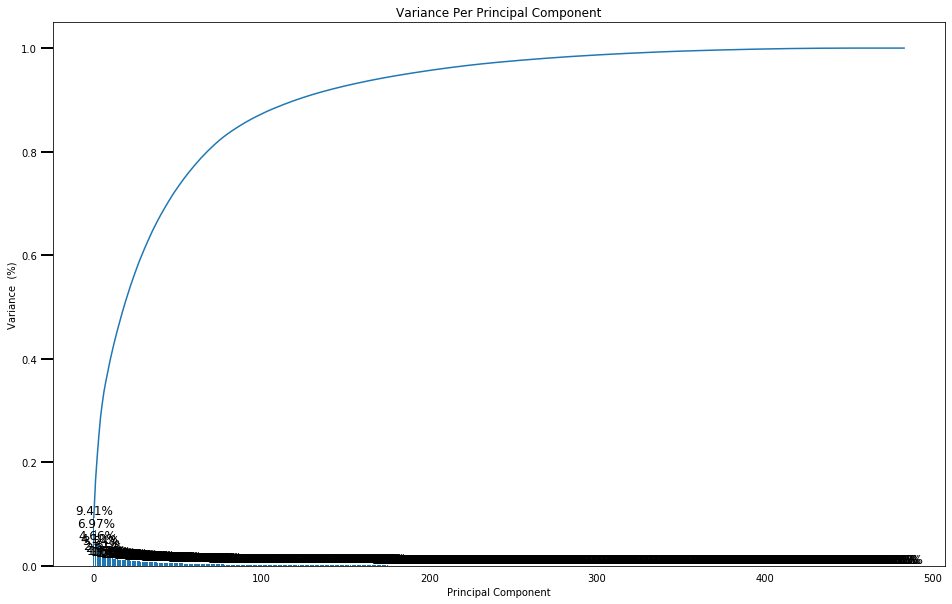

In [76]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [179]:
# Re-apply PCA to the data whith 300 components.
pca = PCA(n_components=300)
azdias_pca = pca.fit_transform(azdias_2)

MemoryError: 

**As we can observe in the above figure, we may notice that after 300 components the cumulative explained variance becomes superior to 0.95. So I will choose 300 features to re-do the PCA.**

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

**perform k-means clustering on the PCA-transformed data.**

In [78]:
# Compute the average within-cluster distances.


def get_kmeans_score(data, center):
    kmeans = KMeans(n_clusters=center, random_state=40, n_jobs=-1)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    
    return score

In [79]:
#elbow method
scores = []
centers = np.arange(2, 15, 1)


for center in centers: 
    scores.append(get_kmeans_score(azdias_pca, center))

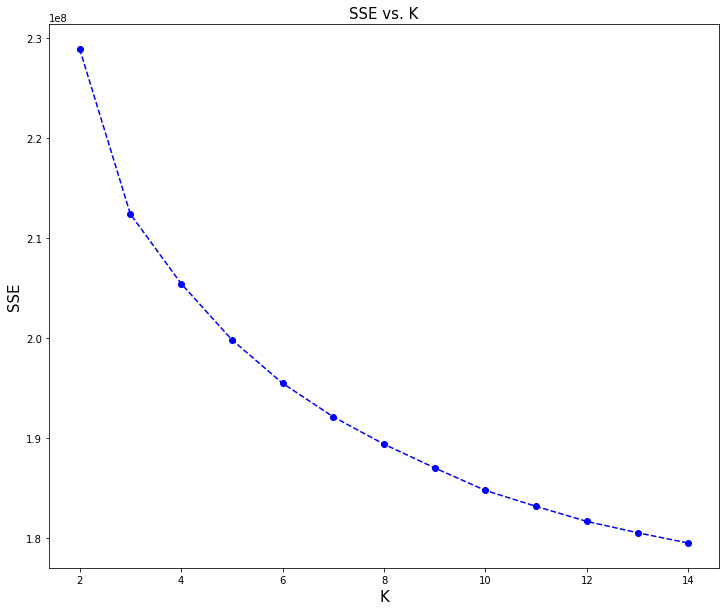

In [80]:
#Change in within-cluster distance among number of clusters.

plt.figure(figsize=(12, 10)) 
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
matplotlib.rc('xtick', labelsize=20)  
matplotlib.rc('ytick', labelsize=20)
plt.xlabel('K', fontsize=15)
plt.ylabel('SSE', fontsize=15)
plt.title('SSE vs. K', fontsize=15)
plt.show() 

**observing at the plot above,there is no clear elbow, but after 6 clusters the decrease is small. I will choose six clusters to do KMeans clustering.**

In [81]:
# Re-fit the k-means model with 6 class
kmeans = KMeans(n_clusters=6, random_state=42, n_jobs=-1)
kmeans_azdias = kmeans.fit_predict(azdias_pca)

In [82]:

counter = pd.Series(kmeans_azdias).value_counts()

cls_azdias = pd.DataFrame({'cluster': counter.index,
                           '% of data': 100*counter.values/len(kmeans_azdias)})
cls_azdias['data'] = 'general population'

# print cls_azdias
cls_azdias

,cluster,% of data,data
0,5,37.457433,general population
1,1,31.198113,general population
2,4,19.177966,general population
3,0,5.323572,general population
4,2,4.975966,general population
5,3,1.866950,general population


### Step 3.2: Apply All Steps to the Customer Data

In [83]:
# Load in the customer demographics data.
cust_pd = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
cust_pd.head()

C:\Users\ahmad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [84]:
# clean customer demographics data.
cust_pd_1 = clean_data(cust_pd)


C:\Users\ahmad\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [85]:
cust_pd_2 = cust_pd_1[['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                               'PRODUCT_GROUP']]

cust_pd_1.drop(['LNR', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE',
                    'PRODUCT_GROUP'], axis=1, inplace=True)

In [86]:
print('new_azdias shape', azdias_2.shape)
print('new_customers shape', cust_pd_2.shape)

new_azdias shape (791987, 484)
new_customers shape (140899, 4)


In [87]:
for i in cust_pd_1.columns:
    print(i)

CJT_GESAMTTYP_1.0
CJT_GESAMTTYP_2.0
CJT_GESAMTTYP_3.0
CJT_GESAMTTYP_4.0
CJT_GESAMTTYP_5.0
CJT_GESAMTTYP_6.0
FINANZTYP_1.0
FINANZTYP_2.0
FINANZTYP_3.0
FINANZTYP_4.0
FINANZTYP_5.0
FINANZTYP_6.0
GFK_URLAUBERTYP_1.0
GFK_URLAUBERTYP_2.0
GFK_URLAUBERTYP_3.0
GFK_URLAUBERTYP_4.0
GFK_URLAUBERTYP_5.0
GFK_URLAUBERTYP_6.0
GFK_URLAUBERTYP_7.0
GFK_URLAUBERTYP_8.0
GFK_URLAUBERTYP_9.0
GFK_URLAUBERTYP_10.0
GFK_URLAUBERTYP_11.0
GFK_URLAUBERTYP_12.0
LP_FAMILIE_FEIN_1.0
LP_FAMILIE_FEIN_2.0
LP_FAMILIE_FEIN_3.0
LP_FAMILIE_FEIN_4.0
LP_FAMILIE_FEIN_5.0
LP_FAMILIE_FEIN_6.0
LP_FAMILIE_FEIN_7.0
LP_FAMILIE_FEIN_8.0
LP_FAMILIE_FEIN_9.0
LP_FAMILIE_FEIN_10.0
LP_FAMILIE_FEIN_11.0
LP_FAMILIE_GROB_1.0
LP_FAMILIE_GROB_2.0
LP_FAMILIE_GROB_3.0
LP_FAMILIE_GROB_4.0
LP_FAMILIE_GROB_5.0
LP_STATUS_FEIN_1.0
LP_STATUS_FEIN_2.0
LP_STATUS_FEIN_3.0
LP_STATUS_FEIN_4.0
LP_STATUS_FEIN_5.0
LP_STATUS_FEIN_6.0
LP_STATUS_FEIN_7.0
LP_STATUS_FEIN_8.0
LP_STATUS_FEIN_9.0
LP_STATUS_FEIN_10.0
LP_STATUS_GROB_1.0
LP_STATUS_GROB_2.0
LP_STATUS_GROB

In [88]:
#  Check for missing column in `new_customers`
missing = azdias_2.columns.isin(cust_pd_1.columns)

missing_attribute = list(azdias_2.columns[~missing])
missing_attribute

['GEBAEUDETYP_5.0']

In [89]:
# Add the missing column with default value of 0
cust_pd_1['GEBAEUDETYP_5.0'] = 0
cust_pd_1['GEBAEUDETYP_5.0'] = cust_pd_1['GEBAEUDETYP_5.0'].astype('uint8')

In [90]:
# replace missing value
cust_pd_1 = pd.DataFrame(Imp.transform(cust_pd_1.values),
                         columns=cust_pd_1.columns)

# scale customers variables
cust_pd_1 = pd.DataFrame(scaler.transform(cust_pd_1.values),
                         columns=cust_pd_1.columns)

In [91]:
# cluster predictions for the  customer demographics data.
cust_pca = pca.transform(cust_pd_1)
labels_cust = kmeans.predict(cust_pca)

In [92]:
customers_class = pd.Series(labels_cust).value_counts()

cls_customers = pd.DataFrame({'cluster': customers_class.index,
                              '% of data': 100*customers_class.values/len(labels_cust)})
cls_customers['data'] = 'customers data'

# print cls_azdias
cls_customers

,cluster,% of data,data
0,1,99.985096,customers data
1,3,0.014904,customers data


#### Step 3.3: Compare Customer Data to Demographics Data

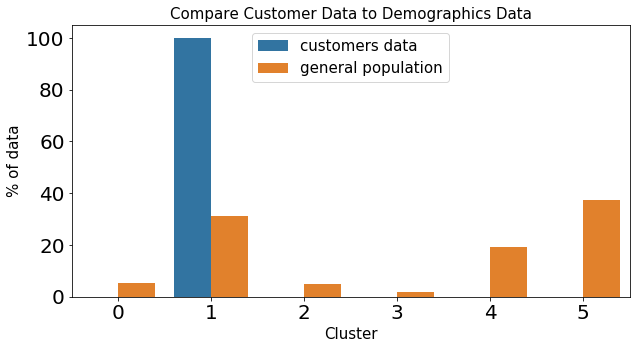

In [93]:
plt.figure(figsize=(10, 5))
sns.barplot(x="cluster", y="% of data", hue="data",
            data=pd.concat([cls_customers, cls_azdias]))
plt.xlabel('Cluster', fontsize=15)
plt.ylabel('% of data', fontsize=15)
plt.title('Compare Customer Data to Demographics Data', fontsize=15)
plt.legend(fontsize=15)
plt.show()

In [94]:
# Select peaple in the target class
target = [4]
targeted_pca = pca.inverse_transform(azdias_pca[np.isin(kmeans_azdias, target)])
targeted_azdias = scaler.inverse_transform(targeted_pca).round()
targeted_azdias = pd.DataFrame(targeted_azdias, columns=azdias_1.columns)

# Get LNR variable
targeted_LNR = LNR_azdias[np.isin(kmeans_azdias, target)]
targeted_azdias['LNR'] = targeted_LNR.values 
 
targeted_azdias.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.0,-0.0,0.0,1.0,-0.0,-0.0,1.0,0.0,0.0,0.0,...,0.0,-0.0,1.0,0.0,1.0,-0.0,0.0,0.0,0.0,645153
1,0.0,-0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,-0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,714263
2,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.0,1.0,-0.0,1.0,0.0,0.0,-0.0,-0.0,796646
3,0.0,0.0,-0.0,1.0,-0.0,0.0,0.0,0.0,-0.0,0.0,...,0.0,0.0,0.0,-0.0,0.0,0.0,0.0,-0.0,1.0,796653
4,-0.0,1.0,0.0,0.0,-0.0,0.0,0.0,1.0,0.0,0.0,...,-0.0,-0.0,0.0,-0.0,1.0,0.0,0.0,0.0,-0.0,796657


In [95]:
# Select peaple in the no target class
no_target = [0,, 2, 3,4,5]
no_targeted_pca = pca.inverse_transform(azdias_pca[np.isin(kmeans_azdias, no_target)])
no_targeted_azdias = scaler.inverse_transform(no_targeted_pca).round()
no_targeted_pca = pd.DataFrame(no_targeted_pca, columns=azdias_1.columns)

# Get LNR variable
no_targeted_LNR = LNR_azdias[np.isin(kmeans_azdias, no_target)]
no_targeted_pca['LNR'] = no_targeted_LNR.values 
 
no_targeted_pca.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0,LNR
0,0.247088,-0.075716,0.106402,-0.155785,0.740907,0.119114,1.141013,0.016003,-0.012243,-0.023258,...,0.473972,0.111645,-0.003152,0.060100,-0.304304,0.054775,0.001775,0.086673,0.136175,910220
1,0.028630,0.171982,0.816815,-0.138607,0.039293,0.078983,0.719051,0.200614,-0.004718,0.148055,...,0.284029,0.016811,0.070340,-0.008381,-0.002649,0.184822,-0.071411,-0.016524,-0.126761,910225
2,-0.080572,0.648922,0.016715,0.021666,0.394299,-0.008809,-0.023032,0.242351,0.100987,-0.079352,...,0.025677,0.045348,0.679820,0.117330,-0.031220,-0.125504,0.126750,-0.028828,0.008137,910226
3,0.293169,-0.303631,0.253038,0.092021,0.293423,0.359053,0.149647,0.106419,0.075565,0.040192,...,-0.152682,0.088023,0.066121,0.000391,-0.697030,0.439475,0.109022,0.118298,-0.030355,910241
4,0.095793,0.679500,0.094952,-0.081710,-0.021020,0.228119,0.393428,0.580547,-0.121121,-0.072021,...,0.049945,0.135844,0.632863,0.063181,-0.116434,0.143260,-0.015406,-0.037607,0.042764,910244


##  <a class="anchor" id="part2">Part 2: Supervised Learning Model</a>

After studying our population and determine which sector of the them tends to be a customer of the mail-order companym next I am going to build the supervised Learning model to predict weather the person is going to be part of the campaign.

I am going to follow CRISP-DM methodology in the next steps. Since I understand the busniess case we have I am going to start by Data Understanding.

## Step 1: Data Understanding

In [96]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv',
                            sep=';')

mailout_train.head()

C:\Users\ahmad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [97]:

print("Total number of records: {}".format(mailout_train.shape[0]))
print("Individuals who became customers: {}".format(mailout_train[mailout_train['RESPONSE'] == 1].shape[0]))
print("Individuals who did not become customers: {}".format( mailout_train[mailout_train['RESPONSE'] == 0].shape[0]))

Total number of records: 42962
Individuals who became customers: 532
Individuals who did not become customers: 42430


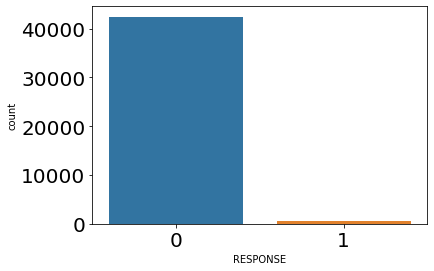

In [98]:
sns.countplot("RESPONSE",data=mailout_train)

**Out of all the 42 962 individuals in the mailout campaign, only 532 of the individuals became customers. The dataset is highly imbalanced, thus we are moving to second stage preparing the data.**

## Step 2: Preparing the Data

In [99]:
# Cleaning data
training_mailout = clean_data(mailout_train)

C:\Users\ahmad\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [100]:
training_mailout.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [101]:
training_mailout.shape

(35100, 485)

In [102]:
# Response values
training_mailout.RESPONSE.value_counts(dropna=False)

0    34663
1      437
Name: RESPONSE, dtype: int64

In [103]:
# Cheking missing values
sum_null = training_mailout.isnull().sum(axis=1).values/485

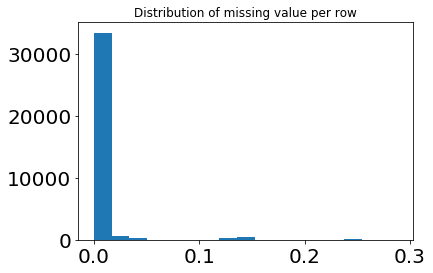

In [104]:
plt.hist(sum_null,bins='auto')
plt.title("Distribution of missing value per row")
plt.show()

In [105]:
# Get LNR variable
mailout_LNR = training_mailout['LNR'] 

# Drop LNR 
training_mailout.drop('LNR', axis=1, inplace=True)

In [106]:
Imp = Imputer(missing_values=np.nan, strategy='median')

C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [107]:
# Imputer
new_mailout = pd.DataFrame(Imp.fit_transform(training_mailout.values),
                          columns=training_mailout.columns)

In [108]:
new_mailout.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [109]:
scaler = RobustScaler()

In [110]:
# feature scaling
new_mailout = pd.DataFrame(scaler.fit_transform(new_mailout.values),
                          columns=training_mailout.columns)

In [111]:
new_mailout.isnull().values.any()

False

In [112]:
# split data to features and labels
target_response = new_mailout['RESPONSE']

# drop RESPONSE variable
features = new_mailout.drop('RESPONSE', axis=1)

In [113]:
new_mailout.shape

(35100, 484)

In [114]:
type(target_response)

pandas.core.series.Series

In [115]:
training_mailout.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [116]:
new_mailout.nunique().to_csv('test.csv')

C:\Users\ahmad\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [118]:
new_mailout['AKT_DAT_KL'].index

RangeIndex(start=0, stop=35100, step=1)

In [119]:

null_columns=new_mailout.columns[new_mailout.isnull().any()]

new_mailout[null_columns].isnull().sum()

Series([], dtype: float64)

In [120]:
target_response.isnull().values.any()

False

## Step 3: Modeling the data 

#### Evaluating Model Performance

Since the data is highly imbalanced, using accuracy as a metric to evaluate model performance will give us a misleading result. Instead, I will use ROC-AUC to assess models performances.


#### Supervised Learning Models
Ensemble methods have become some of the most popular methods used to compete in competitions on Kaggle and used in industry across applications because of their ability to optimize both variance and bias. Therefore in this project, I will test the following three ensemble algorithms:

 - [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
 - [XGBRegressor](https://xgboost.readthedocs.io/en/latest/python/python_api.html)

In [121]:
# Initialize the three models
clf_A = AdaBoostRegressor(random_state=42)
clf_B = RandomForestRegressor(random_state=42)
clf_C = XGBRegressor(random_state=42)

In [122]:
# Initialize the three models


In [123]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target_response, 
                                                    test_size = 0.2)

In [124]:
def modeling_validation(model,X_train, X_test, y_train, y_test):
    
    
    scores = []
    j = 0
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    scores.append(score)

    return scores

In [125]:
models_scores = {}

In [126]:
for clf in [clf_A,clf_B,clf_C]:
    models_scores[clf] = modeling_validation(clf,X_train, X_test, y_train, y_test)

C:\Users\ahmad\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\ahmad\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:11:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [127]:
scores = pd.DataFrame(models_scores)
scores.columns = ['AdaBoostRegressor', 'GradientBoostingRegressor', 'XGBRegressor']
scores

,AdaBoostRegressor,GradientBoostingRegressor,XGBRegressor
0,0.743343,0.619365,0.789291


### Decision
XGBRegressor performed best based on the mean score, so according to the results I am going to choose XGBRegressor
refer to the original paper for more details

http://dmlc.cs.washington.edu/data/pdf/XGBoostArxiv.pdf

## Step 4:  Parameter Tuning

#### Approach for Parameter Tuning :

I refered to this article to implement this step
  [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [128]:
# function for modeling and cross-validation


def cross_validate(alg, X_train, y_train,
             cv_folds=5, early_stopping_rounds=50):
    

        xgb_param = alg.get_xgb_params()
        xgb_train = xgb.DMatrix(X_train, label=y_train)
        
        cv_result = xgb.cv(xgb_param, xgb_train,
                          num_boost_round=alg.get_params()[
                              'n_estimators'], nfold=cv_folds,
                          metrics='auc', verbose_eval=20,
                          early_stopping_rounds=early_stopping_rounds,
                          shuffle=True)
        
        alg.set_params(n_estimators=cv_result.shape[0])
        
        print('n_estimators=', cv_result.shape[0])
        
    # cross-validation
        all_auc = cross_val_score(alg, X_train, y_train,
                              scoring='roc_auc', cv=5,
                              n_jobs=2, verbose=5
                             )
    
        auc = np.average(all_auc)
        print("AUC Score :{} ".format(auc))

In [129]:
# Create initial model and perfrom cross-validation
clf_0 = XGBRegressor(
    objective = 'binary:logistic',
    scale_pos_weight = 1, 
    random_state = 28)

In [130]:
cross_validate(clf_0,X_train, y_train)

C:\Users\ahmad\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[0]	train-auc:0.765387+0.00433603	test-auc:0.761815+0.0144585
[20]	train-auc:0.801397+0.00868273	test-auc:0.771616+0.0181424
[40]	train-auc:0.84515+0.0020746	test-auc:0.770257+0.0193511
[60]	train-auc:0.89289+0.00342685	test-auc:0.777354+0.0170553
[80]	train-auc:0.927122+0.00323022	test-auc:0.777863+0.0156582
[99]	train-auc:0.948011+0.00273599	test-auc:0.777952+0.0138899
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7702186506329568 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.4min finished


In [131]:
clf_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=28, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

#### Tune max_depth and min_child_weight

In [132]:
# Grid seach on subsample and max_features

parameters_1 = {
    'clf_max_depth':range(3,10,2),
    'clf_min_child_weight':range(1,6,2)
}

cv = GridSearchCV(estimator = XGBRegressor( n_estimators=100), param_grid = parameters_1, scoring='roc_auc', n_jobs=-1,
                                           iid=False, cv=5, verbose=10 )
cv.fit(X_train,y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed: 18.6min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.0min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed: 20.0min finished


[15:38:13] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bynode=1,
                                    colsample_bytree=1, gamma=0,
                                    importance_type='gain', learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=None, silent=None,
                                    subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'clf_max_depth': range(3, 10, 2),
                         'clf_min_child_weight': range(1, 6, 2)},


In [133]:
cv.best_score_, cv.best_params_

(0.7732878960999726, {'clf_max_depth': 3, 'clf_min_child_weight': 1})

In [134]:
# Update model
clf_1 = XGBRegressor(
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [135]:
cross_validate(clf_1,X_train, y_train)

[0]	train-auc:0.765387+0.00433603	test-auc:0.761815+0.0144585
[20]	train-auc:0.801397+0.00868273	test-auc:0.771616+0.0181424
[40]	train-auc:0.84515+0.0020746	test-auc:0.770257+0.0193511
[60]	train-auc:0.89289+0.00342685	test-auc:0.777354+0.0170553
[80]	train-auc:0.927122+0.00323022	test-auc:0.777863+0.0156582
[99]	train-auc:0.948011+0.00273599	test-auc:0.777952+0.0138899
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7702186506329568 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.4min finished


#### Tune gamma

In [136]:
parameters_2 = {
    'gamma':[i/10.0 for i in range(0,5)]
}

cv = GridSearchCV(estimator = XGBRegressor( n_estimators=100, max_depth=3, min_child_weight=1, objective='binary:logistic', 
                                           nthread=4, scale_pos_weight=1, seed=27), param_grid = parameters_2, 
                                          scoring='roc_auc', n_jobs=-1,iid=False, cv=5, verbose=10)
cv.fit(X_train,y_train)
cv.best_params_, cv.best_score_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  21 out of  25 | elapsed:  7.8min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  8.2min finished


({'gamma': 0.1}, 0.7720198095189778)

In [137]:
# Update model
clf_2 = XGBRegressor(
    gamma=0.0,
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [138]:
cross_validate(clf_2,X_train, y_train)

[0]	train-auc:0.765387+0.00433603	test-auc:0.761815+0.0144585
[20]	train-auc:0.801397+0.00868273	test-auc:0.771616+0.0181424
[40]	train-auc:0.84515+0.0020746	test-auc:0.770257+0.0193511
[60]	train-auc:0.89289+0.00342685	test-auc:0.777354+0.0170553
[80]	train-auc:0.927122+0.00323022	test-auc:0.777863+0.0156582
[99]	train-auc:0.948011+0.00273599	test-auc:0.777952+0.0138899
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7702186506329568 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.3min finished


#### Tune subsample and colsample_bytree

In [139]:
parameters_3 = {
    'clf__subsample':[i/10.0 for i in range(6,10)],
    'clf__colsample_bytree':[i/10.0 for i in range(6,10)]
}

cv = GridSearchCV(estimator= XGBRegressor(n_estimators=100,gamma=0.0,max_depth = 3,min_child_weight = 1,objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28), param_grid=parameters_3, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)

cv.fit(X_train,y_train)
cv.best_params_, cv.best_score_

({'clf__colsample_bytree': 0.6, 'clf__subsample': 0.6}, 0.7702186506329568)

In [140]:
clf_3 = XGBRegressor(
    subsample = 0.6,
    colsample_bytree = 0.6,
    gamma = 0.0,
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [141]:
cross_validate(clf_3,X_train, y_train)

[0]	train-auc:0.555209+0.108134	test-auc:0.548093+0.096637
[20]	train-auc:0.825158+0.00389451	test-auc:0.77742+0.0221852
[40]	train-auc:0.862892+0.0075845	test-auc:0.775036+0.021752
[60]	train-auc:0.89641+0.00441534	test-auc:0.780801+0.0253988
[80]	train-auc:0.925377+0.00255658	test-auc:0.782371+0.0259624
[99]	train-auc:0.945166+0.00275925	test-auc:0.781402+0.0235135
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7691506069453137 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.9min finished


Note: in this step i modify cross_validate to use one cpu my system is windows, and when i use full cpu's error occurr probably because the system couldn't allocate those resources

### Tuning Regularization Parameters

In [142]:
parameters_4 = {
    'clf__reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

cv = GridSearchCV(estimator=XGBRegressor(
    subsample = 0.6,
    colsample_bytree = 0.6,
    gamma = 0.0,
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28), param_grid=parameters_4, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
cv.fit(X_train,y_train)
cv.best_params_, cv.best_score_

({'clf__reg_alpha': 1e-05}, 0.7691506069453137)

In [143]:
clf_4 = XGBRegressor(
    reg_alpha =  0.00001,
    subsample = 0.6,
    colsample_bytree = 0.6,
    gamma = 0.0,
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28)

In [144]:
cross_validate(clf_4,X_train, y_train)

[0]	train-auc:0.555209+0.108134	test-auc:0.548093+0.096637
[20]	train-auc:0.825158+0.00389451	test-auc:0.77742+0.0221852
[40]	train-auc:0.862892+0.00758412	test-auc:0.775036+0.021752
[60]	train-auc:0.89641+0.00441534	test-auc:0.780801+0.0253988
[80]	train-auc:0.925377+0.00255658	test-auc:0.782371+0.0259624
[99]	train-auc:0.945166+0.00275888	test-auc:0.781402+0.0235135
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7691506069453137 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished


#### Reducing Learning Rate

In [145]:
param_test7 = {
 'learning_rate':[0.05, 0.06, 0.07, 0.08, 0.09, 0.1]
}

cv = GridSearchCV(estimator  = XGBRegressor(
    reg_alpha =  0.00001,
    subsample = 0.6,
    colsample_bytree = 0.6,
    gamma = 0.0,
    max_depth = 3,
    min_child_weight = 1,
    objective = 'binary:logistic',
    scale_pos_weight = 1,
    random_state = 28),
                        param_grid = param_test7, scoring='roc_auc', n_jobs=-1,
                        iid=False, cv=5, verbose=10)
cv.fit(X_train,y_train)
cv.best_params_, cv.best_score_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  27 out of  30 | elapsed:  7.0min remaining:   46.3s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.7min finished


({'learning_rate': 0.05}, 0.7779326504926619)

In [146]:
# final model
model = XGBRegressor(
        learning_rate=0.05,
        n_estimators=100,
        max_depth=3,
        min_child_weight=1,
        gamma=0.0,
        subsample=0.6,
        colsample_bytree=0.6,
        objective='binary:logistic',
        scale_pos_weight=1,
        seed=27,
        random_state=42)

# train the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.6, gamma=0.0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='binary:logistic',
             random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=27, silent=None, subsample=0.6, verbosity=1)

In [147]:
cross_validate(model,X_train, y_train)

[0]	train-auc:0.659703+0.129746	test-auc:0.6529+0.12497
[20]	train-auc:0.804477+0.00230857	test-auc:0.777861+0.0138973
[40]	train-auc:0.833771+0.00487734	test-auc:0.780759+0.0157039
[60]	train-auc:0.852462+0.00378855	test-auc:0.782828+0.0154915
[80]	train-auc:0.867097+0.00266067	test-auc:0.78172+0.0203539
[99]	train-auc:0.883855+0.00141807	test-auc:0.780523+0.0218223
n_estimators= 100


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


AUC Score :0.7795979036032735 


[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  1.8min finished


In [148]:
# feature importance

def feature_plot(importances, X_train, y_train, num_feat=5):
     
    # Display the five most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:num_feat]]
    values = importances[indices][:num_feat]
 
    # Create the plot
    fig = plt.figure(figsize = (16,9))
    plt.title("Normalized Weights for the Most Predictive Features", fontsize = 16)
    plt.barh(np.arange(num_feat), values[::-1], height = 0.6, align="center", \
          label = "Feature Weight")
    plt.barh(np.arange(num_feat) - 0.3, np.cumsum(values)[::-1], height = 0.2, align = "center", \
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(num_feat), columns[::-1])
    plt.xlabel("Weight", fontsize = 12)
    plt.ylabel('')
     
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()

In [149]:
importances = model.feature_importances_

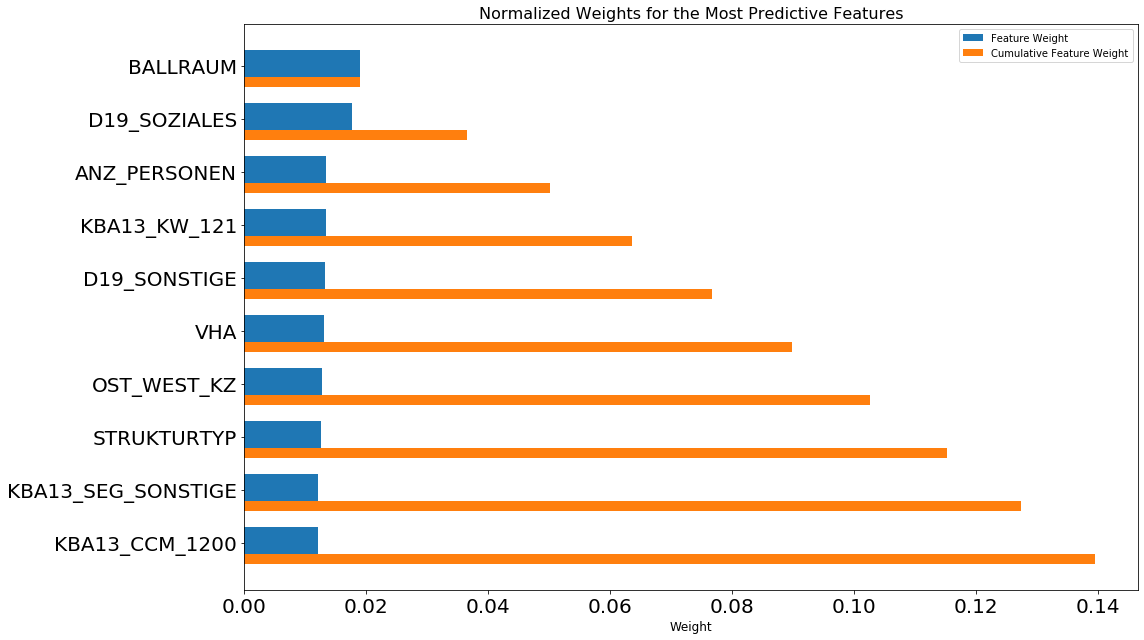

In [150]:
feature_plot(importances, X_train, y_train, 10)

##  <a class="anchor" id="part3">Part 3: Kaggle Competition</a>

 it's time to test that model in competition through [Kaggle](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140).

In [151]:
# Load data
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv',
                           sep=';')
mailout_test.head()

C:\Users\ahmad\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,...,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,...,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,...,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,...,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [152]:
# Clean data
mailout_clean_test = clean_data(mailout_test, drop_row=False)

C:\Users\ahmad\Anaconda3\lib\site-packages\pandas\core\ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


In [153]:
# Drop LNR
mail_test_LNR = mailout_clean_test['LNR']

mailout_clean_test.drop('LNR', axis=1, inplace=True)

In [154]:
# Columns to add
mask_1 = features.columns.isin(mailout_clean_test.columns)
updated_columns = list(features.columns[~mask_1])
updated_columns

[]

In [155]:
# Columns to drop
mask_2 = mailout_clean_test.columns.isin(features.columns)
drop_columns = list(mailout_clean_test.columns[~mask_2])
drop_columns

[]

In [160]:
# Imputer
updated_mailout = pd.DataFrame(Imp.fit_transform(mailout_clean_test.values),
                        columns= mailout_clean_test.columns)

# feature scaling
updated_mailout = pd.DataFrame(scaler.fit_transform(updated_mailout.values),
                        columns= updated_mailout.columns)

updated_mailout.head()

,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1.0,FINANZTYP_2.0,FINANZTYP_3.0,FINANZTYP_4.0,...,WOHNLAGE_3.0,WOHNLAGE_4.0,WOHNLAGE_5.0,WOHNLAGE_7.0,WOHNLAGE_8.0,PLZ8_BAUMAX_1.0,PLZ8_BAUMAX_2.0,PLZ8_BAUMAX_3.0,PLZ8_BAUMAX_4.0,PLZ8_BAUMAX_5.0
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [168]:
pd.DataFrame(X_train.columns).to_csv("train.csv")

In [169]:
# Prediction
updated_labels = model.predict(updated_mailout)


In [170]:
results = pd.DataFrame(updated_labels, index=mail_test_LNR.astype('int32'),
                          columns=["RESPONSE"])

results.head()

,RESPONSE
LNR,
1754,0.035581
1770,0.031497
1465,0.008458
1470,0.008680
1478,0.008449


In [172]:
# Save file to submit
results.to_csv('response.csv')

In [177]:
del(azdias)

NameError: name 'azdias' is not defined

In [178]:
del(azdias_1)